<a href="https://colab.research.google.com/github/nassunie/Mid-Project_Nasya.github.io.io/blob/main/EfficientNetB0_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install split-folders

In [11]:
import os
import shutil
import random

# Tentukan Path
base_path = '/content/drive/MyDrive/thesis/Dataset_Tanaman/CNN/All_dataset'
target_path = '/content/drive/MyDrive/thesis/Dataset_Tanaman/CNN/split_dataset'
classes = ['Blast', 'Blight', 'Healthy']

for cls in classes:
    # Buat Folder Tujuan
    os.makedirs(os.path.join(target_path, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(target_path, 'val', cls), exist_ok=True)
    os.makedirs(os.path.join(target_path, 'test', cls), exist_ok=True)

    # Ambil semua file dan acak
    src_folder = os.path.join(base_path, cls)
    all_files = os.listdir(src_folder)
    random.seed(42)
    random.shuffle(all_files)

    # Hitung batas split
    train_bound = int(len(all_files) * 0.8)
    val_bound = int(len(all_files) * 0.9)

    # Bagi file
    train_files = all_files[:train_bound]
    val_files = all_files[train_bound:val_bound]
    test_files = all_files[val_bound:]

    # Fungsi untuk menyalin file
    def copy_files(files, folder_type):
        for f in files:
            shutil.copy(os.path.join(src_folder, f),
                        os.path.join(target_path, folder_type, cls, f))

    copy_files(train_files, 'train')
    copy_files(val_files, 'val')
    copy_files(test_files, 'test')

print("Dataset berhasil dipisahkan!")

Dataset berhasil dipisahkan!


In [12]:
import os
import shutil
import random

# 1. Tentukan Path
base_path = '/content/drive/MyDrive/thesis/Dataset_Tanaman/CNN/All_dataset'
target_path = '/content/drive/MyDrive/thesis/Dataset_Tanaman/CNN/split_dataset'
cls = 'Healthy' # Fokus hanya pada kelas ini

# 2. Buat Folder Tujuan (Train, Val, Test) jika belum ada
for folder in ['train', 'val', 'test']:
    os.makedirs(os.path.join(target_path, folder, cls), exist_ok=True)

# 3. Akses Folder Sumber
src_folder = os.path.join(base_path, cls)

if not os.path.exists(src_folder):
    print(f"❌ ERROR: Folder '{cls}' tidak ditemukan. Silakan cek apakah namanya 'Healthy' atau 'healthy'.")
else:
    # Ambil semua file dan acak
    all_files = os.listdir(src_folder)
    print(f"📂 Ditemukan {len(all_files)} file di dalam folder {cls}.")

    if len(all_files) > 0:
        random.seed(42)
        random.shuffle(all_files)

        # 4. Hitung batas split (80% Train, 10% Val, 10% Test)
        train_bound = int(len(all_files) * 0.8)
        val_bound = int(len(all_files) * 0.9)

        train_files = all_files[:train_bound]
        val_files = all_files[train_bound:val_bound]
        test_files = all_files[val_bound:]

        # 5. Fungsi untuk menyalin file
        def copy_specific_files(files, folder_type):
            count = 0
            for f in files:
                shutil.copy(os.path.join(src_folder, f),
                            os.path.join(target_path, folder_type, cls, f))
                count += 1
            print(f"✅ Berhasil menyalin {count} file ke folder {folder_type}/{cls}")

        # Eksekusi penyalinan
        copy_specific_files(train_files, 'train')
        copy_specific_files(val_files, 'val')
        copy_specific_files(test_files, 'test')

        print(f"\n🎉 Pemisahan kelas {cls} selesai dengan sukses!")
    else:
        print(f"⚠️ Folder {cls} ditemukan, tetapi tidak ada file di dalamnya.")

📂 Ditemukan 1820 file di dalam folder Healthy.
✅ Berhasil menyalin 1456 file ke folder train/Healthy
✅ Berhasil menyalin 182 file ke folder val/Healthy
✅ Berhasil menyalin 182 file ke folder test/Healthy

🎉 Pemisahan kelas Healthy selesai dengan sukses!


In [15]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# ==========================================
# 1. KONFIGURASI & LOAD DATASET
# ==========================================
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 1e-4
EPOCHS_MAX = 50
DATASET_PATH = '/content/drive/MyDrive/thesis/Dataset_Tanaman/CNN/split_dataset' # Sesuaikan ini

# Memuat dataset training (Asli)
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

# Memuat dataset validasi (Asli)
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'val'),
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

# AMBIL JUMLAH KELAS DI SINI (Sebelum Prefetch)
class_names = raw_train_ds.class_names
num_classes = len(class_names)
print(f"Detected classes: {class_names}")

# Optimasi data pipeline (Baru diubah ke PrefetchDataset)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ==========================================
# 2. MEMBANGUN ARSITEKTUR MODEL
# ==========================================
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_input(inputs)

    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)

    # TAHAP 1: Freeze backbone
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = models.Model(inputs, outputs, name="EfficientNetB0_TransferLearning")
    return model, base_model

model, base_model = build_model(num_classes)

# ==========================================
# 3. SETTING CALLBACKS
# ==========================================
my_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
]

# ==========================================
# 4. TRAINING TAHAP 1: FEATURE EXTRACTION
# ==========================================
print("\n[INFO] Memulai Tahap 1: Melatih Head...")
model.compile(
    optimizer=optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=my_callbacks
)

# ==========================================
# 5. TRAINING TAHAP 2: FINE-TUNING
# ==========================================
print("\n[INFO] Memulai Tahap 2: Fine-Tuning...")

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_MAX,
    initial_epoch=history_phase1.epoch[-1],
    callbacks=my_callbacks
)

Found 2999 files belonging to 3 classes.
Found 374 files belonging to 3 classes.
Detected classes: ['Blast', 'Blight', 'Healthy']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

[INFO] Memulai Tahap 1: Melatih Head...
Epoch 1/15


Copying files: 15 files [22:54, 91.62s/ files]


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3903 - loss: 1.3961

94/94 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.3908 - loss: 1.3947 - val_accuracy: 0.5989 - val_loss: 0.8705 - learning_rate: 1.0000e-04
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5831 - loss: 0.9373

94/94 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.5833 - loss: 0.9367 - val_accuracy: 0.7086 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6648 - loss: 0.7374

94/94 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.6649 - loss: 0.7373 - val_accuracy: 0.7781 - val_loss: 0.5797 - learning_rate: 1.0000e-04
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7097 - loss: 0.6691

94/94 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.7097 - loss: 0.6688 - val_accuracy: 0.8182 - val_loss: 0.5021 - learning_rate: 1.0000e-04
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7324 - loss: 0.5941

94/94 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.7324 - loss: 0.5940 - val_accuracy: 0.8316 - val_loss: 0.4507 - learning_rate: 1.0000e-04
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7608 - loss: 0.5405

94/94 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.7608 - loss: 0.5405 - val_accuracy: 0.8449 - val_loss: 0.4161 - learning_rate: 1.0000e-04
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7714 - loss: 0.5070

94/94 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.7715 - loss: 0.5070 - val_accuracy: 0.8529 - val_loss: 0.3953 - learning_rate: 1.0000e-04
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7910 - loss: 0.4783

94/94 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.7909 - loss: 0.4783 - val_accuracy: 0.8610 - val_loss: 0.3765 - learning_rate: 1.0000e-04
Epoch 9/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7930 - loss: 0.4837

94/94 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.7931 - loss: 0.4835 - val_accuracy: 0.8717 - val_loss: 0.3621 - learning_rate: 1.0000e-04
Epoch 10/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8280 - loss: 0.4117

94/94 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.8278 - loss: 0.4121 - val_accuracy: 0.8770 - val_loss: 0.3469 - learning_rate: 1.0000e-04
Epoch 11/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8250 - loss: 0.4105

94/94 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.8248 - loss: 0.4107 - val_accuracy: 0.8797 - val_loss: 0.3419 - learning_rate: 1.0000e-04
Epoch 12/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8156 - loss: 0.4340

94/94 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.8157 - loss: 0.4337 - val_accuracy: 0.8850 - val_loss: 0.3348 - learning_rate: 1.0000e-04
Epoch 13/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8347 - loss: 0.4098

94/94 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.8347 - loss: 0.4098 - val_accuracy: 0.8877 - val_loss: 0.3292 - learning_rate: 1.0000e-04
Epoch 14/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.8221 - loss: 0.3952 - val_accuracy: 0.8824 - val_loss: 0.3192 - learning_rate: 1.0000e-04
Epoch 15/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8252 - loss: 0.3926

94/94 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.8253 - loss: 0.3926 - val_accuracy: 0.8930 - val_loss: 0.3143 - learning_rate: 1.0000e-04

[INFO] Memulai Tahap 2: Fine-Tuning...
Epoch 15/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.7257 - loss: 0.6523 - val_accuracy: 0.8850 - val_loss: 0.3240 - learning_rate: 1.0000e-05
Epoch 16/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.7912 - loss: 0.5090 - val_accuracy: 0.8797 - val_loss: 0.3144 - learning_rate: 1.0000e-05
Epoch 17/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.7794 - loss: 0.4945 - val_accuracy: 0.8797 - val_loss: 0.3004 - learning_rate: 1.0000e-05
Epoch 18/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8192 - loss: 0.4134 - val_accuracy: 0.8850 - val_loss: 0.2875 - learning_rate: 1.0000e-05
Epoch 19/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8334 - loss: 0.3837

94/94 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.8334 - loss: 0.3838 - val_accuracy: 0.8957 - val_loss: 0.2751 - learning_rate: 1.0000e-05
Epoch 20/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8347 - loss: 0.3661

94/94 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.8348 - loss: 0.3661 - val_accuracy: 0.9011 - val_loss: 0.2641 - learning_rate: 1.0000e-05
Epoch 21/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8461 - loss: 0.3537

94/94 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.8462 - loss: 0.3536 - val_accuracy: 0.9091 - val_loss: 0.2577 - learning_rate: 1.0000e-05
Epoch 22/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8426 - loss: 0.3509

94/94 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.8427 - loss: 0.3507 - val_accuracy: 0.9118 - val_loss: 0.2504 - learning_rate: 1.0000e-05
Epoch 23/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.8508 - loss: 0.3423 - val_accuracy: 0.9118 - val_loss: 0.2430 - learning_rate: 1.0000e-05
Epoch 24/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8742 - loss: 0.3080

94/94 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.8742 - loss: 0.3079 - val_accuracy: 0.9144 - val_loss: 0.2373 - learning_rate: 1.0000e-05
Epoch 25/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8698 - loss: 0.3120

94/94 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.8699 - loss: 0.3118 - val_accuracy: 0.9198 - val_loss: 0.2312 - learning_rate: 1.0000e-05
Epoch 26/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8817 - loss: 0.2889

94/94 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.8817 - loss: 0.2888 - val_accuracy: 0.9225 - val_loss: 0.2259 - learning_rate: 1.0000e-05
Epoch 27/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.8886 - loss: 0.2661 - val_accuracy: 0.9198 - val_loss: 0.2250 - learning_rate: 1.0000e-05
Epoch 28/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8908 - loss: 0.2577

94/94 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.8908 - loss: 0.2577 - val_accuracy: 0.9251 - val_loss: 0.2199 - learning_rate: 1.0000e-05
Epoch 29/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.8918 - loss: 0.2729 - val_accuracy: 0.9225 - val_loss: 0.2155 - learning_rate: 1.0000e-05
Epoch 30/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8943 - loss: 0.2545

94/94 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.8943 - loss: 0.2544 - val_accuracy: 0.9278 - val_loss: 0.2122 - learning_rate: 1.0000e-05
Epoch 31/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.9136 - loss: 0.2230 - val_accuracy: 0.9278 - val_loss: 0.2092 - learning_rate: 1.0000e-05
Epoch 32/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9043 - loss: 0.2321

94/94 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.9044 - loss: 0.2321 - val_accuracy: 0.9332 - val_loss: 0.2058 - learning_rate: 1.0000e-05
Epoch 33/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.9172 - loss: 0.2144 - val_accuracy: 0.9278 - val_loss: 0.2046 - learning_rate: 1.0000e-05
Epoch 34/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.9116 - loss: 0.2222 - val_accuracy: 0.9305 - val_loss: 0.2022 - learning_rate: 1.0000e-05
Epoch 35/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9308 - loss: 0.1879

94/94 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.9307 - loss: 0.1880 - val_accuracy: 0.9358 - val_loss: 0.1988 - learning_rate: 1.0000e-05
Epoch 36/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9169 - loss: 0.2052 - val_accuracy: 0.9358 - val_loss: 0.1972 - learning_rate: 1.0000e-05
Epoch 37/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.9250 - loss: 0.1861 - val_accuracy: 0.9305 - val_loss: 0.1959 - learning_rate: 1.0000e-05
Epoch 38/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.9235 - loss: 0.1824 - val_accuracy: 0.9305 - val_loss: 0.1946 - learning_rate: 1.0000e-05
Epoch 39/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.9239 - loss: 0.1931 - val_accuracy: 0.9305 - val_loss: 0.1941 - learning_rate: 1.0000e-05
Epoch 40/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.9346 - loss: 0.1653 - val_accuracy: 0.9305 - val_loss: 0.1934 - learning_rate: 1.0000e-05
Epoch 41/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.9328 - los

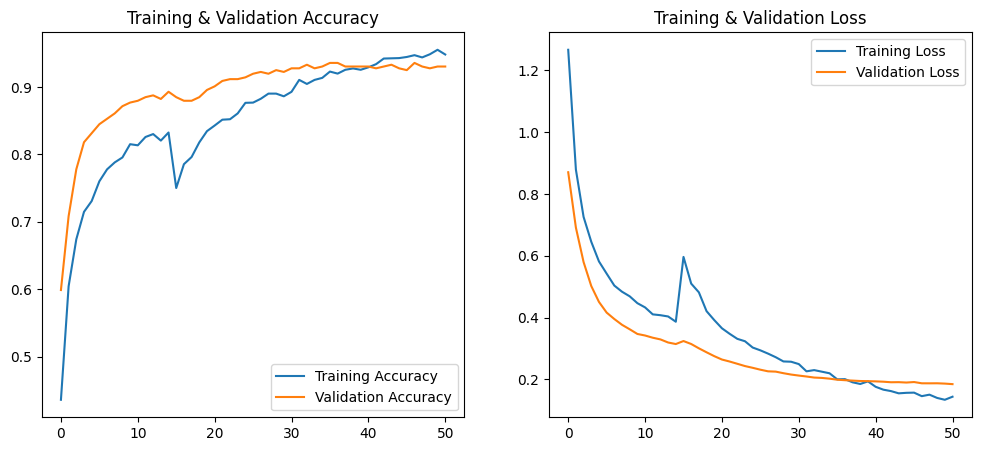

In [16]:
import matplotlib.pyplot as plt

def plot_history(history_phase1, history_phase2):
    # Menggabungkan history dari kedua fase
    acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
    val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
    loss = history_phase1.history['loss'] + history_phase2.history['loss']
    val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.show()

plot_history(history_phase1, history_phase2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

       Blast       0.93      0.88      0.91       130
      Blight       1.00      0.94      0.97        62
     Healthy       0.91      0.96      0.94       182

    accuracy                           0.93       374
   macro avg       0.95      0.93      0.94       374
weighted avg       0.93      0.93      0.93       374



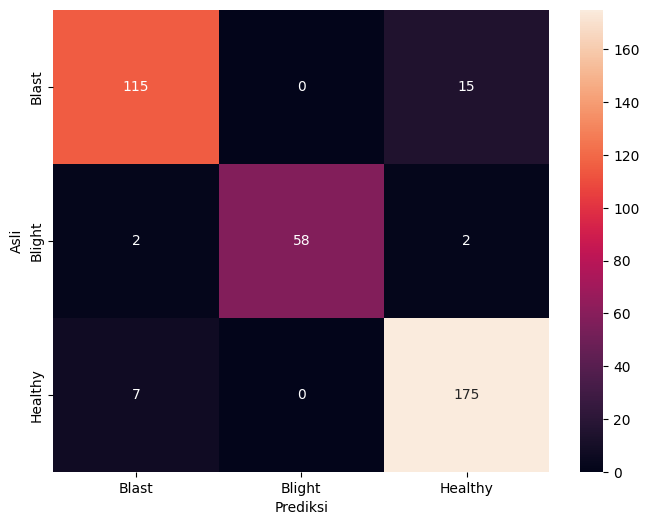

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Ambil label asli dan prediksi
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Tampilkan Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Asli')
plt.show()

In [18]:
# Menyimpan seluruh arsitektur, bobot, dan konfigurasi optimizer
model.save('model_efficientnet_final.h5')
print("Model berhasil disimpan!")

Model berhasil disimpan!


In [19]:
from google.colab import files
files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>